In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
#import seaborn as sns
from itertools import product
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel
from codes.kernels_pairwise import spectrum_kernel_pw, sum_onehot_spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In this notebook, we plot kernel matrix using two kernels:
* spectrum kernel (l = 3)
* sum of spectrum kernel (split each string into three parts A [:7] + B [7:13] + C [13:]. The reason we consider sum of kernel is that each part has high correlations to itself, but less with the other two)

We observe the results for three groups of input:

* 4 seqs selected from edit one sequence, 4 seqs selected from the uniform random sequence. 
* first round results (totoally 90 seqs)
* baseline sequences

The normalisation of kernel is based on each sub-parts, and is not done with the sum of kernels. There is two issues worth considering:
* after center and unit norm, the kernel matrix is not unit variance, which violates the statement from section 4.4.2 in http://jmlr.csail.mit.edu/papers/volume12/kloft11a/kloft11a.pdf
* whether directly adding up kernels makes sense. 

## Reading Dataset

In [2]:
# Data contains both the first round result and baseline data
#
# columns: 
# RBS: 20-length RBS seq
# RBS6: 6-length RBS seq, which the [7:13] positions
# variable: for first round results, denote which replication is the seq. 
# label: normalised label (zero mean and unit variance)
#       For the first round result, label is the (GFPOD(t0 + h) - GFPOR(t0))/h,
#                                   where t0 is the turning time point
#                                         h is the time interval (e.g. 4h)
#       For the baseline data, label is the TIR used in previous paper
#       Both of the two labels express the slope, but in different scales (calculation methods are slightly different)
#       We normalise the labels as zero mean and unit variance respectively

Path = '../../data/firstRound_4h+Baseline.csv'

df = pd.read_csv(Path)
df.head()

,Unnamed: 0,AVERAGE,Group,RBS,RBS6,STD,label,variable
0,0,2.592357,bps,TTTAAGAAGGAGATATACAT,AGGAGA,0.717515,3.194925,Rep1
1,1,1.604161,bps,CTTAAGAAGGAGATATACAT,AGGAGA,0.284382,1.844257,Rep1
2,2,0.662662,bps,GTTAAGAAGGAGATATACAT,AGGAGA,0.017069,0.674610,Rep1
3,3,1.678999,bps,ATTAAGAAGGAGATATACAT,AGGAGA,0.500712,1.986839,Rep1
4,4,1.671743,bps,TCTAAGAAGGAGATATACAT,AGGAGA,0.624388,1.830061,Rep1


In [3]:
df_FRR = df[df['Group'] == 'First round result']
df_BD = df[df['Group'] == 'Baseline data']

data = np.asarray(df[['RBS', 'label']])
data_FRR = np.asarray(df_FRR[['RBS', 'label']])
data_BD = np.asarray(df_BD[['RBS', 'label']])

In [4]:
# indicates whether cross validation (KFOLD)
cross_val_flag = False 

# indicates whether plot predict_label vs. true label
plot_flag = True 

# regression evaluation metric, 'NRMSE' or 'r2_score'
metric = 'NRMSE'

# string kernel list 
# kernels = [spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw]
#kernels = [sum_onehot_spectrum_kernel_pw]
spec_kernel = Spectrum_Kernel()
sum_spec_kernel = Sum_Spectrum_Kernel()

kernels = [sum_spec_kernel]

models = [GaussianProcessRegressor]

# name dictionaries
regression_name = {KernelRidge: 'KR',
                  GaussianProcessRegressor: 'GPR'}
embedding_name = ['onehot', 'kmer', 'label']

train_scores = {}
test_scores = {}
trained_reg_model_dict = {}

data_dict = {
             'all': data,
             'First round result': data_FRR,
             'Baseline data': data_BD,
             None: None
            }

alpha = 1e-10 # Value added to the diagonal of the kernel matrix during fitting.

plot_flag = True

## Plot kernel matrix for several sequences

In [5]:
# edit one
a = np.asarray(['TTTAAGAAGGAGATATACAT', 'CTTAAGAAGGAGATATACAT', 'GTTAAGAAGGAGATATACAT', 'ATTAAGAAGGAGATATACAT'])
# random 
b = np.asarray(['TTTAAGACCCGAATATACAT', 'TTTAAGAAATGTCTATACAT', 'TTTAAGACGTACCTATACAT', 'TTTAAGAACCGTGTATACAT'])
# combine
c = np.concatenate((a,b))
c

array(['TTTAAGAAGGAGATATACAT', 'CTTAAGAAGGAGATATACAT',
       'GTTAAGAAGGAGATATACAT', 'ATTAAGAAGGAGATATACAT',
       'TTTAAGACCCGAATATACAT', 'TTTAAGAAATGTCTATACAT',
       'TTTAAGACGTACCTATACAT', 'TTTAAGAACCGTGTATACAT'], dtype='<U20')

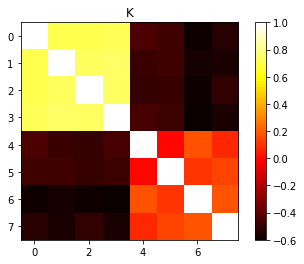

In [6]:
K = spec_kernel.__call__(c,c, plot_flag=plot_flag)

In [7]:
K

array([[ 1.        ,  0.7182782 ,  0.71290775,  0.7289581 , -0.44240101,
        -0.47122843, -0.58239114, -0.53042148],
       [ 0.7182782 ,  1.        ,  0.74199726,  0.75178485, -0.48547736,
        -0.47401905, -0.56764003, -0.55964001],
       [ 0.71290775,  0.74199726,  1.        ,  0.74896112, -0.50072403,
        -0.48890587, -0.58316849, -0.50632274],
       [ 0.7289581 ,  0.75178485,  0.74896112,  1.        , -0.45634155,
        -0.47919891, -0.60083218, -0.56257326],
       [-0.44240101, -0.48547736, -0.50072403, -0.45634155,  1.        ,
        -0.00298593,  0.17852943,  0.07696385],
       [-0.47122843, -0.47401905, -0.48890587, -0.47919891, -0.00298593,
         1.        ,  0.10894735,  0.1445141 ],
       [-0.58239114, -0.56764003, -0.58316849, -0.60083218,  0.17852943,
         0.10894735,  1.        ,  0.18091135],
       [-0.53042148, -0.55964001, -0.50632274, -0.56257326,  0.07696385,
         0.1445141 ,  0.18091135,  1.        ]])

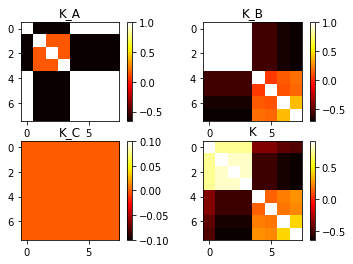

array([[ 0.9       ,  0.73377338,  0.73377338,  0.73377338, -0.3495292 ,
        -0.3488792 , -0.43316254, -0.46338364],
       [ 0.73377338,  0.9       ,  0.81578947,  0.81578947, -0.51575582,
        -0.51510582, -0.59938916, -0.62961026],
       [ 0.73377338,  0.81578947,  0.9       ,  0.81578947, -0.51575582,
        -0.51510582, -0.59938916, -0.62961026],
       [ 0.73377338,  0.81578947,  0.81578947,  0.9       , -0.51575582,
        -0.51510582, -0.59938916, -0.62961026],
       [-0.3495292 , -0.51575582, -0.51575582, -0.51575582,  0.9       ,
         0.15005502,  0.21803279,  0.26002223],
       [-0.3488792 , -0.51510582, -0.51510582, -0.51510582,  0.15005502,
         0.9       ,  0.20011004,  0.23996494],
       [-0.43316254, -0.59938916, -0.59938916, -0.59938916,  0.21803279,
         0.20011004,  0.9       ,  0.42004445],
       [-0.46338364, -0.62961026, -0.62961026, -0.62961026,  0.26002223,
         0.23996494,  0.42004445,  0.9       ]])

In [8]:
sum_spec_kernel.__call__(c,c, plot_flag=plot_flag)

## Plot kernel matrix for first round result

In [9]:
frr_seqs = np.asarray(df[df['variable'] == 'Rep1']['RBS'])

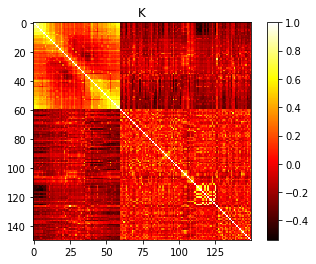

array([[ 1.        ,  0.79907615,  0.79800808, ..., -0.42405076,
        -0.37017924, -0.25180023],
       [ 0.79907615,  1.        ,  0.81880912, ..., -0.31856743,
        -0.301666  , -0.23657494],
       [ 0.79800808,  0.81880912,  1.        , ..., -0.34749252,
        -0.24936862, -0.23914375],
       ...,
       [-0.42405076, -0.31856743, -0.34749252, ...,  1.        ,
         0.04413987,  0.13756042],
       [-0.37017924, -0.301666  , -0.24936862, ...,  0.04413987,
         1.        , -0.01368394],
       [-0.25180023, -0.23657494, -0.23914375, ...,  0.13756042,
        -0.01368394,  1.        ]])

In [10]:
spec_kernel.__call__(frr_seqs, frr_seqs, plot_flag=plot_flag)

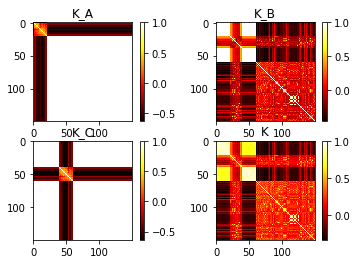

array([[ 1.        ,  0.86698669,  0.86628122, ..., -0.14244134,
        -0.16478214, -0.09087541],
       [ 0.86698669,  1.        ,  0.94590827, ..., -0.27545465,
        -0.29779546, -0.22388873],
       [ 0.86628122,  0.94590827,  1.        , ..., -0.27616012,
        -0.29850092, -0.22459419],
       ...,
       [-0.14244134, -0.27545465, -0.27616012, ...,  1.        ,
         0.29724331,  0.31235219],
       [-0.16478214, -0.29779546, -0.29850092, ...,  0.29724331,
         1.        ,  0.35188943],
       [-0.09087541, -0.22388873, -0.22459419, ...,  0.31235219,
         0.35188943,  1.        ]])

In [11]:
sum_spec_kernel.__call__(frr_seqs, frr_seqs, plot_flag=plot_flag)

In [12]:
frr_seqs

array(['TTTAAGAAGGAGATATACAT', 'CTTAAGAAGGAGATATACAT',
       'GTTAAGAAGGAGATATACAT', 'ATTAAGAAGGAGATATACAT',
       'TCTAAGAAGGAGATATACAT', 'TGTAAGAAGGAGATATACAT',
       'TATAAGAAGGAGATATACAT', 'TTGAAGAAGGAGATATACAT',
       'TTAAAGAAGGAGATATACAT', 'TTTCAGAAGGAGATATACAT',
       'TTTGAGAAGGAGATATACAT', 'TTTTAGAAGGAGATATACAT',
       'TTTACGAAGGAGATATACAT', 'TTTAGGAAGGAGATATACAT',
       'TTTATGAAGGAGATATACAT', 'TTTAACAAGGAGATATACAT',
       'TTTAAAAAGGAGATATACAT', 'TTTAATAAGGAGATATACAT',
       'TTTAAGCAGGAGATATACAT', 'TTTAAGGAGGAGATATACAT',
       'TTTAAGTAGGAGATATACAT', 'TTTAAGACGGAGATATACAT',
       'TTTAAGAGGGAGATATACAT', 'TTTAAGATGGAGATATACAT',
       'TTTAAGAACGAGATATACAT', 'TTTAAGAAAGAGATATACAT',
       'TTTAAGAATGAGATATACAT', 'TTTAAGAAGCAGATATACAT',
       'TTTAAGAAGAAGATATACAT', 'TTTAAGAAGTAGATATACAT',
       'TTTAAGAAGGCGATATACAT', 'TTTAAGAAGGGGATATACAT',
       'TTTAAGAAGGTGATATACAT', 'TTTAAGAAGGACATATACAT',
       'TTTAAGAAGGAAATATACAT', 'TTTAAGAAGGATATATACAT',
       'TT

## Plot kernel matrix for baseline data

In [13]:
baseline_seqs = np.asarray(df[df['Group'] == 'Baseline data']['RBS'])

In [14]:
baseline_seqs

array(['TTAAGTAAGCGGGGAAAATA', 'TTAAGTAGACGCGGAAAATA',
       'TTAAGTAAGCGCGGAAAATA', 'TTAAGTAAACGAGGAAAATA',
       'TTAAGTAGGCGAGGAAAATA', 'TTAAGTAGGCGCGGAAAATA',
       'TTAAGTAAACGGGGAAAATA', 'TTAAGTAAACGCGGAAAATA',
       'TTAAGTAGACGAGGAAAATA', 'TTAAGTAGGCGGGGAAAATA',
       'TTAAGTAGGCGAGGAAAATA', 'TTAAGTAGACGGGGAAAATA',
       'TTAAGTAAACGGGGAAAATA', 'AGCATCTAAGGGGGATACTA',
       'AGCATCTAAGAGGGGTACTA', 'AGCATCTAAGGGGGGTACTA',
       'AGCATCTAAGGGGGCTACTA', 'AGCATCTAAGAGGGATACTA',
       'AGCATCTAAGAGCGATACTA', 'AGCATCTAAGGGCGGTACTA',
       'AGCATCTAAGAGGGCTACTA', 'AGCATCTAAGGGCGCTACTA',
       'AGCATCTAAGAGCGGTACTA', 'AGCATCTAAGGGCGATACTA',
       'AGCATCTAAGAGCGCTACTA', 'AGCATCTAAGGGCGGTACTA',
       'AGCATCTAAGAGGGCTACTA', 'TTTAAGGAAGGAACGTACAT',
       'TTTAAGGACGTAACGTACAT', 'TTTAAGGAAGGAACGTACAT',
       'TTTAAGGAAGAAACGTACAT', 'TTTAAGGAAGAAACGTACAT',
       'TTTAAGGAGGAAACGTACAT', 'TTTAAGGAAGGAACGTACAT',
       'TTTAAGGACGTAACGTACAT', 'TTTAAGGAAGTAACGTACAT',
       'TT

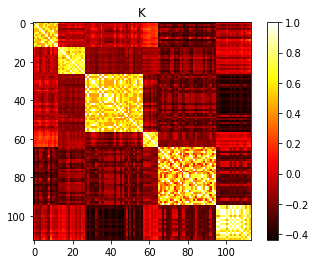

In [15]:
kernel = spec_kernel.__call__(baseline_seqs, baseline_seqs, plot_flag=plot_flag)

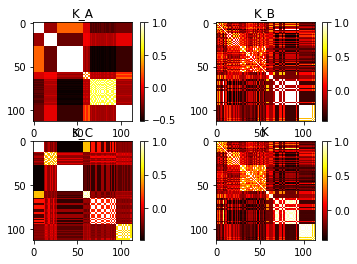

array([[ 1.        ,  0.3117573 ,  0.55681611, ...,  0.02056664,
         0.01833199,  0.01725196],
       [ 0.3117573 ,  1.        ,  0.61620703, ..., -0.32113677,
        -0.25822623, -0.32445144],
       [ 0.55681611,  0.61620703,  1.        , ..., -0.19043964,
        -0.19250171, -0.19375431],
       ...,
       [ 0.02056664, -0.32113677, -0.19043964, ...,  1.        ,
         0.5434902 ,  0.95810113],
       [ 0.01833199, -0.25822623, -0.19250171, ...,  0.5434902 ,
         1.        ,  0.58538907],
       [ 0.01725196, -0.32445144, -0.19375431, ...,  0.95810113,
         0.58538907,  1.        ]])

In [16]:
sum_spec_kernel.__call__(baseline_seqs, baseline_seqs, plot_flag=plot_flag)